### Preliminaries
- make new branch

### Fit a detector
- copy boiler plate code. This shouldnt take too long

In [4]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
### Set CUDA device
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [6]:
from typing import List, Dict, Union
import numpy as np
import torch
from torch import Tensor, nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import sys
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict
from torchvision.transforms import GaussianBlur
from torchmetrics.functional.classification import dice
from tqdm.auto import tqdm
from torchmetrics.classification import BinaryPrecisionRecallCurve
from sklearn.metrics import auc

## Augmentations
from batchgenerators.transforms.noise_transforms import augment_gaussian_blur

sys.path.append('../')
from data_utils import get_eval_data
from model.unet import get_unet
from utils import  epoch_average, UMapGenerator
from model.mahalanobis_adatper import (
    get_pooling_mahalanobis_detector, 
    get_batchnorm_mahalanobis_detector
)
from model.wrapper import PoolingMahalanobisWrapper, BatchNormMahalanobisWrapper


from matplotlib.colors import ListedColormap, Normalize

def format_e(n):
    a = '%e' % n
    return a.split('e')[0].rstrip('0').rstrip('.') + 'e' + a.split('e')[1]


# Create a custom colormap - transparent for class 0, and different colors for other classes
seg_colors = ['none', 'yellow', 'green', 'blue']  # 'none' for transparent
err_colors = ['none', 'red']
seg_cmap = ListedColormap(seg_colors)
err_cmap = ListedColormap(err_colors)

# Ensure the colormap is normalized to the number of classes
seg_norm = Normalize(vmin=0, vmax=len(seg_colors)-1)
err_norm = Normalize(vmin=0, vmax=len(err_colors)-1)



nnUNet_raw_data_base is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
RESULTS_FOLDER is not defined and nnU-Net cannot be used for training or inference. If this is not intended behavior, please read documentation/setting_up_paths.md for information on how to set this up.


In [7]:
### Load basic config
cfg = OmegaConf.load('../configs/basic_config_venusberg.yaml')
OmegaConf.update(cfg, 'run.iteration', 0)

In [8]:
### Set dataset, either brain or heart
DATA_KEY = 'heart'
OmegaConf.update(cfg, 'run.data_key', DATA_KEY)


### get model
# available models:
#     - default-8
#     - default-16
#     - monai-8-4-4
#     - monai-16-4-4
#     - monai-16-4-8
#     - monai-32-4-4
#     - monai-64-4-4
#     - swinunetr


unet_name = 'default-8'
postfix = '_all'
args = unet_name.split('-')
cfg.unet[DATA_KEY].pre = unet_name + postfix
cfg.unet[DATA_KEY].arch = args[0]
cfg.unet[DATA_KEY].n_filters_init = int(args[1])

if args[0] == 'monai':
    cfg.unet[DATA_KEY].depth = int(args[2])
    cfg.unet[DATA_KEY].num_res_units = int(args[3])

unet, state_dict = get_unet(
    cfg,
    update_cfg_with_swivels=False,
    return_state_dict=True)
unet.load_state_dict(state_dict)
_ = unet.cuda().eval()

In [9]:
# Set debug mode for only a small fraction of the datasets. Speeds up this cell by alot
cfg.debug = False

# update config with default values
OmegaConf.update(
    cfg, 
    'eval',
    OmegaConf.load('../configs/eval/unet_config.yaml')
)

# Wether and how you want to subset in case of Brain data. WARNING:
# After subsetting the eval below will not work with surface
# Dice anymore, because volumes are fragmented. 
APPLY_SUBSETTING = True
OmegaConf.update(cfg, 'eval.data.subset.apply', APPLY_SUBSETTING)
subset_params = {
    'n_cases': 256,  # selects at most so many cases
    'fraction': 0.1, # selects from the 10% worst cases w.r.t to a model
}
OmegaConf.update(
    cfg, 
    'eval.data.subset.params', 
    OmegaConf.create(subset_params)
)

if cfg.eval.data.subset.apply:
    subset_dict = OmegaConf.to_container(
        cfg.eval.data.subset.params, 
        resolve=True, 
        throw_on_missing=True
    )
    subset_dict['unet'] = unet
else:
    subset_dict = None

### select the datasets within the domain
# get training data
cfg.eval.data.training = True
# get validation data
cfg.eval.data.validation = True
# get testing data
# Options for Brain are any subset of [1, 2, 3, 4, 5] or 'all' 
# Options for Heart are any subset of ['A', 'B', 'C', 'D'] or 'all'
cfg.eval.data.testing = 'all' #['A'] #
cfg.data.heart.mnm.selection = 'non_empty_target' # 'all_cases' #'non_empty_target'

data = get_eval_data(
    train_set=cfg.eval.data.training,
    val_set=cfg.eval.data.validation,
    test_sets=cfg.eval.data.testing,    
    cfg=cfg,
    subset_dict=subset_dict
)

dataloader = DataLoader(
    data['train'], 
    batch_size=32, 
    shuffle=False, 
    drop_last=False
)

print(f'\nAvailable datasets are: {list(data.keys())}')

loading dataset
loading all case properties
loading dataset
loading all case properties
loading dataset
loading all case properties
loading dataset
loading all case properties
loading dataset
loading all case properties
loading dataset
loading all case properties

Available datasets are: ['train', 'val', 'A', 'B', 'C', 'D']


In [305]:
dataloader = DataLoader(data['train'], 
    batch_size=32, 
    shuffle=False, 
    drop_last=False
)

swivels = [layer[0] for layer in unet.named_modules() if 'bn' in layer[0]]
sequential = False


# detector = get_pooling_mahalanobis_detector(
#     swivels=swivels,
#     unet=unet,
#     pool='avg3d',
#     sigma_algorithm='default',
#     fit='raw',
#     dist_fn='mahalanobis',
#     iid_data=dataloader,
#     transform=True,
#     lr=1e-4,
#     sequential=sequential,
#     device='cuda:0'
# )


detector = get_pooling_mahalanobis_detector(
    swivels=swivels,
    unet=unet,
    pool='none',
    sigma_algorithm='diagonal',
    fit='raw',
    dist_fn='squared_mahalanobis',
    iid_data=dataloader,
    transform=True,
    lr=1e-4,
    sequential=sequential,
    device='cuda:0'
)



### Find threshold
- look up old code
    - use collect_validation to get valiation representations
    - use merge_validation to get 


- write validation data fit function
- integrate into class


In [306]:
detector.set_collect_mode('validation_data')
detector.train()

valid_loader = DataLoader(data['val'], batch_size=32, shuffle=False, drop_last=False)

for batch in valid_loader:
    _ = detector(batch['input'].cuda())

detector.find_threshold()

print(detector.adapters[0].threshold, detector.adapters[0].swivel)


tensor(311610.0625) init_path.2.conv_path.0.bn


### Intermediate goal: find good attachment point, test all
- how good is the OOD detection for single/all layer(s)

In [307]:
test_loader = DataLoader(
    data['D'], 
    batch_size=32, 
    shuffle=False, 
    drop_last=True
)

detector.eval()


preds = {}
for batch in test_loader:
    _ = detector(batch['input'].cuda())
    for adapter in detector.adapters:
        preds.setdefault(adapter.swivel, []).append(adapter.ood_pred)

# quick evaluation
max = 0
for key in preds:
    preds[key] = torch.cat(preds[key])
    pred = preds[key].sum().item() / preds[key].shape[0]
    if pred > max:
        max = pred
        max_key = key

print(max, max_key)

0.8112980769230769 init_path.2.conv_path.0.bn


### Write loss_fn and try fixing an image
- check image_restoration.ipynb for copy pasting
- see how well the new image does in terms of Dice

In [13]:
@torch.no_grad()
def eval_heart_set(
    model: nn.Module, 
    dataloader: DataLoader, 
) -> Dict:
    model.eval()

    DSCs = {'0': []}

    for batch in dataloader:
        input_ = batch['input']
        target = batch['target'].long()
        target[target == -1] = 0

        net_out_original = model(input_.cuda()).detach().cpu()
        segmap_original = torch.argmax(net_out_original, dim=1, keepdims=True)
        DSCs['0'].append(
            torch.tensor([dice(
                    s.flatten(), 
                    t.flatten(),
                    num_classes=4,
                    zero_division=1,
                    average='macro'
                ) for s,t in zip(segmap_original, target)]
            ).cpu()
        )

    return DSCs


def total_variation_loss(img):
    """
    Compute the Total Variation Loss.
    img should be a 4D tensor of shape (N, C, H, W).
    """
    # Calculate the difference of neighboring pixel-values.
    # The variation is calculated for both the x and y dimensions.
    # loss_fn = torch.nn.HuberLoss(reduction='none')
    # pixel_dif1 = loss_fn(img[1:, :], img[:-1, :])  # Difference in height (y-axis)
    # pixel_dif2 = loss_fn(img[:, 1:], img[:, :-1])  # Difference in width (x-axis)
    pixel_dif1 = img[:, :, 1:, :] - img[:, :, :-1, :]  # Difference in height (y-axis)
    pixel_dif2 = img[:, :, :, 1:] - img[:, :, :, :-1]  # Difference in width (x-axis)

    
    
    # Calculate the total variation by taking the sum of absolute values of the pixel differences.
    # The means is for all spatial dimensions.
    tv_loss = torch.mean(torch.abs(pixel_dif1)) + torch.mean(torch.abs(pixel_dif2))

    return tv_loss




In [263]:
site = 'C'

dataloader = DataLoader(data[site], 
    batch_size=32, 
    shuffle=False, 
    drop_last=False
)

DCSs = eval_heart_set(unet, dataloader)
values, indices = torch.cat(DCSs['0']).sort()

In [349]:
index = indices[250]
n_iter = 1000


img = data[site][index]['input'].unsqueeze(0)
# img_restored = img.clone().detach().requires_grad_(True)

target = data[site][index]['target'].squeeze()
# img_restored[:, :, target > 0] = img_restored[:, :, target > 0].requires_grad_(True) 
unet.eval()
params = torch.zeros_like(img[:, :, target > 0]).requires_grad_(True) 
# params = torch.zeros_like(img).requires_grad_(True)
# optimizer = torch.optim.Adam([params], lr=1e-2)

optimizer = torch.optim.Adam([params], lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

In [350]:
# loop
frac_on = 1
with tqdm(range(n_iter)) as t:
    for i in t:
        t.set_description(f'Fraction of adapters on: {frac_on:.2f}')
        optimizer.zero_grad()
        
        loss = torch.tensor(0, dtype=torch.float32).cuda()
        img_restored = img.clone()
        img_restored[:, :, target > 0] = img_restored[:, :, target > 0] + params
        # img_restored = img_restored + params
        _ = detector(img_restored.cuda())

        frac_on = (torch.tensor([adapter.transform_loss for adapter in detector.adapters]) > 0).sum() / len(detector.adapters)
        for adapter in detector.adapters:
            loss += adapter.transform_loss
        # loss *= 10000
        # loss /= 1e2
        loss /= 1e4
        if i % 50 == 0:
            print(loss.item())
        # print(loss.item())
        # adapter_losses = torch.tensor([adapter.transform_loss for adapter in detector.adapters])
        
        # loss += adapter_losses.sum()
        # print(loss)
        # frac_on = (adapter_losses.detach() > 0).sum() / len(adapter_losses.detach())
        diff = img.detach() - img_restored
        if i > 0:
            loss += (total_variation_loss(diff)) * 100
            # loss += (total_variation_loss(diff)) * 10
            # print((total_variation_loss(diff)) * 0.5)
        # print(loss.item())
        # print()
        loss.backward()
        # img_restored.grad.data[:, :, target <= 0] = 0
        optimizer.step()

Fraction of adapters on: 1.00:   0%|          | 0/1000 [00:00<?, ?it/s]

Fraction of adapters on: 0.04:   0%|          | 2/1000 [00:00<01:11, 13.93it/s]

44.63450622558594


Fraction of adapters on: 0.04:   5%|▌         | 51/1000 [00:06<02:09,  7.33it/s]

44.23342514038086


Fraction of adapters on: 0.04:  10%|█         | 102/1000 [00:12<01:54,  7.87it/s]

44.188072204589844


Fraction of adapters on: 0.04:  15%|█▌        | 152/1000 [00:19<01:45,  8.07it/s]

44.16873550415039


Fraction of adapters on: 0.04:  20%|██        | 201/1000 [00:26<02:03,  6.45it/s]

44.16081619262695


Fraction of adapters on: 0.04:  25%|██▌       | 251/1000 [00:33<02:04,  6.00it/s]

44.15968322753906


Fraction of adapters on: 0.04:  30%|███       | 301/1000 [00:41<02:01,  5.76it/s]

44.157737731933594


Fraction of adapters on: 0.04:  35%|███▌      | 352/1000 [00:48<01:37,  6.68it/s]

44.15673065185547


Fraction of adapters on: 0.04:  40%|████      | 400/1000 [00:55<01:40,  5.98it/s]

44.156314849853516


Fraction of adapters on: 0.04:  45%|████▌     | 452/1000 [01:03<01:17,  7.04it/s]

44.154998779296875


Fraction of adapters on: 0.04:  50%|█████     | 501/1000 [01:09<01:06,  7.51it/s]

44.15439987182617


Fraction of adapters on: 0.04:  55%|█████▌    | 552/1000 [01:16<01:02,  7.20it/s]

44.153106689453125


Fraction of adapters on: 0.04:  60%|██████    | 602/1000 [01:23<00:48,  8.22it/s]

44.15281677246094


Fraction of adapters on: 0.04:  65%|██████▌   | 651/1000 [01:30<00:52,  6.62it/s]

44.15278625488281


Fraction of adapters on: 0.04:  70%|███████   | 701/1000 [01:37<00:41,  7.21it/s]

44.15269088745117


Fraction of adapters on: 0.04:  75%|███████▌  | 752/1000 [01:44<00:33,  7.30it/s]

44.15253448486328


Fraction of adapters on: 0.04:  80%|████████  | 802/1000 [01:52<00:27,  7.11it/s]

44.15207290649414


Fraction of adapters on: 0.04:  85%|████████▌ | 852/1000 [01:58<00:18,  7.88it/s]

44.15165328979492


Fraction of adapters on: 0.04:  90%|█████████ | 902/1000 [02:05<00:12,  7.91it/s]

44.15192794799805


Fraction of adapters on: 0.04:  95%|█████████▌| 952/1000 [02:11<00:05,  8.67it/s]

44.15201950073242


Fraction of adapters on: 0.04: 100%|██████████| 1000/1000 [02:17<00:00,  7.28it/s]


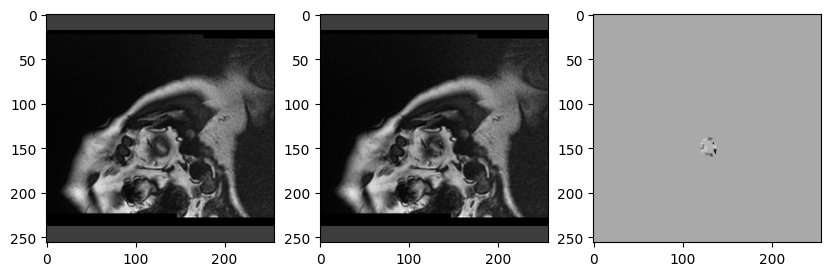

In [351]:
### plot img and img_restored side by side
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(img[0, 0].cpu().numpy(), cmap='gray')
ax[1].imshow(img_restored[0, 0].detach().cpu().numpy(), cmap='gray')
ax[2].imshow(diff[0, 0].detach().cpu().numpy(), cmap='gray')

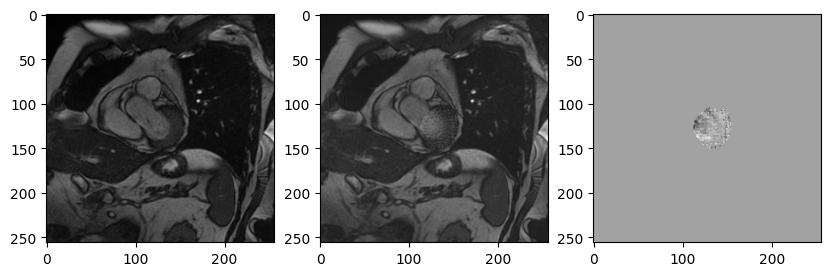

In [266]:
### plot img and img_restored side by side
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(img[0, 0].cpu().numpy(), cmap='gray')
ax[1].imshow(img_restored[0, 0].detach().cpu().numpy(), cmap='gray')
ax[2].imshow(diff[0, 0].detach().cpu().numpy(), cmap='gray')

79
318


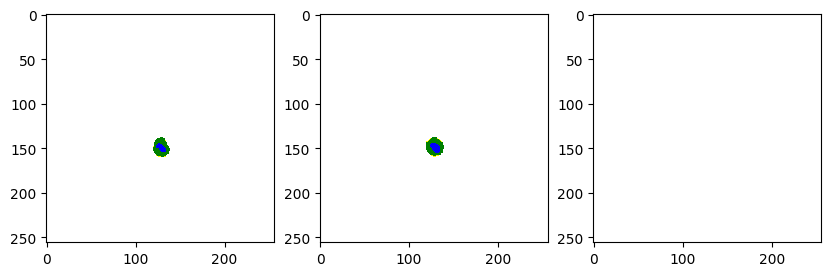

In [352]:
output_orig = torch.argmax(unet(img.cuda()), dim=1).squeeze()
output_restored = torch.argmax(unet(img_restored.cuda()), dim=1).squeeze()

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(target.cpu().numpy(), cmap=seg_cmap, norm=seg_norm)
# ax[1].imshow(output_orig.cpu().numpy() != target.cpu().numpy(), cmap='gray')
# ax[2].imshow(output_restored.cpu().numpy() != target.cpu().numpy(), cmap='gray')
ax[1].imshow(output_orig.cpu().numpy(), cmap=seg_cmap, norm=seg_norm)
ax[2].imshow(output_restored.cpu().numpy(), cmap=seg_cmap, norm=seg_norm)
print((output_orig.cpu().numpy() != target.cpu().numpy()).sum())
print((output_restored.cpu().numpy() != target.cpu().numpy()).sum())

1520
768


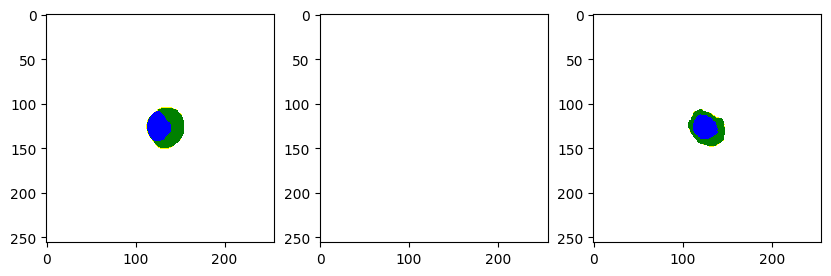

In [267]:
output_orig = torch.argmax(unet(img.cuda()), dim=1).squeeze()
output_restored = torch.argmax(unet(img_restored.cuda()), dim=1).squeeze()

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(target.cpu().numpy(), cmap=seg_cmap, norm=seg_norm)
# ax[1].imshow(output_orig.cpu().numpy() != target.cpu().numpy(), cmap='gray')
# ax[2].imshow(output_restored.cpu().numpy() != target.cpu().numpy(), cmap='gray')
ax[1].imshow(output_orig.cpu().numpy(), cmap=seg_cmap, norm=seg_norm)
ax[2].imshow(output_restored.cpu().numpy(), cmap=seg_cmap, norm=seg_norm)
print((output_orig.cpu().numpy() != target.cpu().numpy()).sum())
print((output_restored.cpu().numpy() != target.cpu().numpy()).sum())

### 

In [130]:
@torch.no_grad()
def eval_heart_set(
    model: nn.Module, 
    dataloader: DataLoader, 
) -> Dict:
    model.eval()
    
    # Gaussian Params (from gaussian_filter, scipy)
    blurs = []
    truncate=4.0

    DSCs = {'0': []}

    # saves batch sizes for each batch for averaging
    for batch in dataloader:
        input_ = batch['input']
        target = batch['target'].long()
        # convert -1 labels to background
        target[target == -1] = 0
        # # convert to one-hot encoding
        # target = F.one_hot(
        #     target.long(), 
        #     num_classes=4
        # ).squeeze(1).permute(0,3,1,2)
        # get model output
        net_out_original = model(input_.cuda()).detach().cpu()
        segmap_original = torch.argmax(net_out_original, dim=1, keepdims=True)
        DSCs['0'].append(
            torch.tensor([dice(
                    s.flatten(), 
                    t.flatten(),
                    num_classes=4,
                    zero_division=1,
                    average='macro'
                ) for s,t in zip(segmap_original, target)]
            ).cpu()
        )

    return DSCs

In [131]:
dataloader = DataLoader(data['B'], 
    batch_size=32, 
    shuffle=False, 
    drop_last=False
)

DCSs = eval_heart_set(unet, dataloader)

In [133]:
values, indices = torch.cat(DCSs['0']).sort()
index = 150 # indices[torch.linspace(150, 550, 20, dtype=torch.int)]
img = data['B'][index]['input'].unsqueeze(0)
img_restored = img.clone().detach().requires_grad_(True)
target = data['B'][index]['target']

n_iter = 1000
unet.eval()
optimizer = torch.optim.Adam([img_restored], lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# loop
for i in range(n_iter):
    optimizer.zero_grad()
    
    loss = torch.tensor(0, dtype=torch.float32).cuda()
    _ = detector(img_restored.cuda())

    for adapter in detector.adapters:
        loss += adapter.transform_loss
    # print(loss.item(), ((total_variation_loss(diff)) * 0.5).item())
    if i > 0:
        diff = img.detach() - img_restored
        loss += (total_variation_loss(diff)) * 1000
        # print((total_variation_loss(diff)) * 0.5)
    loss.backward()
    optimizer.step()

In [1]:
v

NameError: name 'v' is not defined

In [99]:
detector.eval()
detector.set_transform(True)

_ = detector(test_in.cuda())

In [100]:
for adapter in detector.adapters:
    print(adapter.transform_loss)

tensor(277.3906, device='cuda:0', grad_fn=<SumBackward0>)
tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
tensor(99.7354, device='cuda:0', grad_fn=<SumBackward0>)
tensor(82.1275, device='cuda:0', grad_fn=<SumBackward0>)
tensor(96.1378, device='cuda:0', grad_fn=<SumBackward0>)
tensor(79.3433, device='cuda:0', grad_fn=<SumBackward0>)
tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
tensor(34.6188, device='cuda:0', grad_fn=<SumBackward0>)
tensor(30.1692, device='cuda:0', grad_fn=<SumBackward0>)
tensor(33.3979, device='cuda:0', grad_fn=<SumBackward0>)
tensor(31.7388, device='cuda:0', grad_fn=<SumBackward0>)
tensor(30.5072, device='cuda:0', grad_fn=<SumBackward0>)
tensor(168.92